In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
class ModelBasedOPE:
    def __init__(self):
        self.dynamics_model = None
        self.reward_model = None

        self.state_features = ['est_x', 'est_y', 'est_yaw', 'pos_uncertainty', 'yaw_uncertainty_deg']
        self.action_features = ['v_cmd', 'omega_cmd']

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['est_yaw'] = df['est_yaw'].apply(lambda x: np.arctan2(np.sin(x), np.cos(x)))
        return df

    def create_transitions(self, df):
        states = df[self.state_features].values[:-1]
        actions = df[self.action_features].values[:-1]
        next_states = df[self.state_features].values[1:]
        rewards = df['reward'].values[:-1]

        next_states[:, 2] = np.arctan2(np.sin(next_states[:, 2]),np.cos(next_states[:, 2]))
        return states, actions, next_states, rewards

    def train_dynamics_model(self, df_behavior, test_size=0.2):
        states, actions, next_states, _ = self.create_transitions(df_behavior)
        X = np.hstack([states, actions])
        y = next_states

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        self.dynamics_model = []
        results = []

        feature_names = ['x', 'y', 'yaw', 'pos_unc', 'yaw_unc']

        for dim in range(y.shape[1]):
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=15,
                min_samples_leaf=3,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train, y_train[:, dim])

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val[:, dim], y_pred)
            r2 = r2_score(y_val[:, dim], y_pred)

            results.append({'feature': feature_names[dim], 'mse': mse, 'r2': r2})
            self.dynamics_model.append(model)

            print(f"{feature_names[dim]:12} MSE: {mse:.4f}  R²: {r2:.4f}")

        print()
        return pd.DataFrame(results)

    def train_reward_model(self, df_behavior, test_size=0.2):
        X = df_behavior[self.state_features].values
        y = df_behavior['reward'].values

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

        self.reward_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        )
        self.reward_model.fit(X_train, y_train)

        y_pred = self.reward_model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        print(f"MSE: {mse:.4f}")
        print(f"R²:  {r2:.4f}")

        importances = list(zip(self.state_features,self.reward_model.feature_importances_))
        importances.sort(key=lambda x: x[1], reverse=True)

        print("\nTop Feature Importances:")
        for feat, imp in importances:
            print(f"  {feat:25} {imp:.4f}")
        print()

        return {'mse': mse, 'r2': r2, 'importances': importances}

    def simulate_policy(self, initial_state, df_target): #for simulating evaluation policy
        current_state = initial_state.copy()
        predicted_rewards = []
        predicted_states = [current_state.copy()]

        horizon = len(df_target) - 1

        for t in range(horizon):
            action = df_target[self.action_features].iloc[t].values
            X = np.hstack([current_state, action]).reshape(1, -1)
            next_state = np.zeros(len(self.state_features))

            for i, model in enumerate(self.dynamics_model):
                next_state[i] = model.predict(X)[0]

            next_state[2] = np.arctan2(
                np.sin(next_state[2]),
                np.cos(next_state[2])
            )

            reward = self.reward_model.predict(next_state.reshape(1, -1))[0]
            predicted_rewards.append(reward)
            predicted_states.append(next_state.copy())

            current_state = next_state

        total_reward = np.sum(predicted_rewards)

        print(f"Steps simulated: {len(predicted_rewards)}")
        print(f"Mean reward/step: {np.mean(predicted_rewards):.4f}")
        print(f"Total reward: {total_reward:.1f}")
        print()

        return {
            'total_reward': total_reward,
            'rewards': predicted_rewards,
            'states': np.array(predicted_states)
        }

    def evaluate(self, df_behavior, df_target):
        initial_state = df_behavior[self.state_features].iloc[0].values

        sim_result = self.simulate_policy(initial_state, df_target)

        predicted = sim_result['total_reward']
        true_value = df_target['cumulative_reward'].iloc[-1]

        error_abs = abs(predicted - true_value)
        error_pct = 100 * error_abs / abs(true_value)

        print(f"Predicted cumulative reward: {predicted:.1f}")
        print(f"True cumulative reward:      {true_value:.1f}")
        print(f"Absolute error:              {error_abs:.1f}")
        print(f"Percent error:               {error_pct:.1f}%")
        print()

        return {
            'predicted': predicted,
            'true': true_value,
            'error_abs': error_abs,
            'error_pct': error_pct,
            'simulation': sim_result
        }


Model-based OPE with RandomForest method

Behavior policy (σ=0.8): 4885 timesteps
Target policy (σ=0.4):   4896 timesteps

x            MSE: 0.0002  R²: 1.0000
y            MSE: 0.0001  R²: 1.0000
yaw          MSE: 0.0901  R²: 0.9705
pos_unc      MSE: 0.0000  R²: 0.9993
yaw_unc      MSE: 0.7955  R²: 0.9712

MSE: 1.3685
R²:  0.7619

Top Feature Importances:
  pos_uncertainty           0.5079
  yaw_uncertainty_deg       0.1679
  est_y                     0.1307
  est_yaw                   0.1065
  est_x                     0.0870

Steps simulated: 4895
Mean reward/step: 16.0433
Total reward: 78531.9

Predicted cumulative reward: 78531.9
True cumulative reward:      17936.5
Absolute error:              60595.4
Percent error:               337.8%

Saved figure: model_based_ope_rf.png


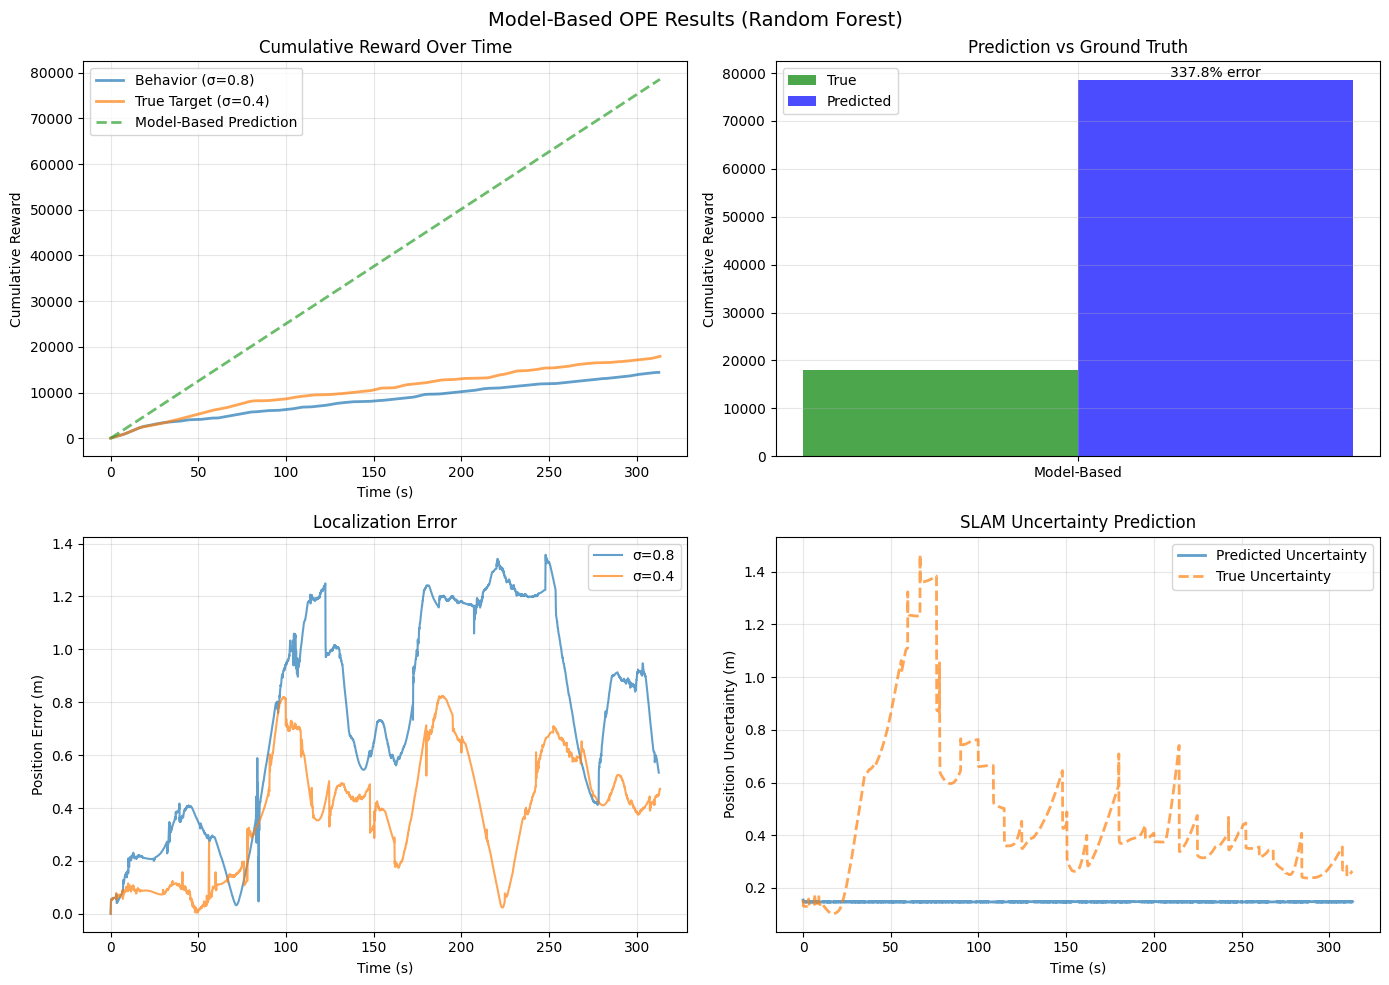

In [ ]:
def visualize_results(df_behavior, df_target, evaluation_result):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax = axes[0, 0]
    sim_rewards = evaluation_result['simulation']['rewards']
    sim_cumulative = np.cumsum(sim_rewards)

    min_len = min(len(sim_cumulative), len(df_target))
    time_sim = df_target['time'].iloc[:min_len]

    ax.plot(df_behavior['time'], df_behavior['cumulative_reward'],
            label=f"Behavior (σ={df_behavior['sigma_policy'].iloc[0]})",
            linewidth=2, alpha=0.7)
    ax.plot(df_target['time'], df_target['cumulative_reward'],
            label=f"True Target (σ={df_target['sigma_policy'].iloc[0]})",
            linewidth=2, alpha=0.7)
    ax.plot(time_sim, sim_cumulative[:min_len],
            label='Model-Based Prediction',
            linewidth=2, linestyle='--', alpha=0.7)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Cumulative Reward Over Time')
    ax.legend()
    ax.grid(alpha=0.3)
    ax = axes[0, 1]
    predicted = evaluation_result['predicted']
    true_val = evaluation_result['true']
    error_pct = evaluation_result['error_pct']

    x = [0]
    width = 0.4

    ax.bar(x[0] - width/2, true_val, width, label='True', alpha=0.7, color='green')
    ax.bar(x[0] + width/2, predicted, width, label='Predicted', alpha=0.7, color='blue')

    ax.text(x[0] + width/2, predicted, f'{error_pct:.1f}% error',
            ha='center', va='bottom', fontsize=10)

    ax.set_xticks([0])
    ax.set_xticklabels(['Model-Based'])
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Prediction vs Ground Truth')
    ax.legend()
    ax.grid(alpha=0.3)

    ax = axes[1, 0]
    ax.plot(df_behavior['time'], df_behavior['pos_error'],
            label=f"σ={df_behavior['sigma_policy'].iloc[0]}",
            alpha=0.7)
    ax.plot(df_target['time'], df_target['pos_error'],
            label=f"σ={df_target['sigma_policy'].iloc[0]}",
            alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position Error (m)')
    ax.set_title('Localization Error')
    ax.legend()
    ax.grid(alpha=0.3)

    ax = axes[1, 1]
    predicted_states = evaluation_result['simulation']['states']
    ax.plot(time_sim, predicted_states[:min_len, 3],
            label='Predicted Uncertainty', linewidth=2, alpha=0.7)
    ax.plot(df_target['time'].iloc[:min_len], df_target['pos_uncertainty'].iloc[:min_len],label='True Uncertainty', linewidth=2,linestyle='--', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position Uncertainty (m)')
    ax.set_title('SLAM Uncertainty Prediction')
    ax.legend()
    ax.grid(alpha=0.3)

    plt.suptitle('Model-Based OPE Results (Random Forest)', fontsize=14)
    plt.tight_layout()
    return fig


if __name__ == "__main__":
    print("Model-based OPE with RandomForest method")
    print()

    evaluator = ModelBasedOPE()
    df_behavior = evaluator.load_data('ekf_slam_logging_sigma0.8.csv')
    df_target = evaluator.load_data('ekf_slam_evaluation_sigma0.4.csv')

    print(f"Behavior policy (σ=0.8): {len(df_behavior)} timesteps")
    print(f"Target policy (σ=0.4):   {len(df_target)} timesteps")
    print()

    dynamics_metrics = evaluator.train_dynamics_model(df_behavior)
    reward_metrics = evaluator.train_reward_model(df_behavior)
    results = evaluator.evaluate(df_behavior, df_target)

    fig = visualize_results(df_behavior, df_target, results)
    plt.savefig('model_based_ope_rf.png', dpi=300, bbox_inches='tight')
    print("Saved figure: model_based_ope_rf.png")